In [5]:
!pip install -q opencv-python-headless gluoncv

In [28]:
import json
import cv2
import boto3
import numpy as np
import sagemaker
import base64
from matplotlib import pyplot as plt
import gluoncv
import mxnet as mx
import sagemaker
from sagemaker import get_execution_role
from sagemaker.mxnet.model import MXNetModel
role = sagemaker.get_execution_role()

print(cv2.__version__)
print(mx.__version__)

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20210316T173364 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


4.5.1
1.8.0


In [7]:
!wget -nc https://raw.githubusercontent.com/kts102121/lambda_container/master/dog.jpg

File ‘dog.jpg’ already there; not retrieving.



![title](dog.jpg)

In [8]:
!wget -nc https://pjreddie.com/media/files/yolov3.weights
!wget -nc https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget -nc https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

File ‘yolov3.weights’ already there; not retrieving.

File ‘yolov4.cfg’ already there; not retrieving.

File ‘yolov3.cfg’ already there; not retrieving.

File ‘coco.names’ already there; not retrieving.



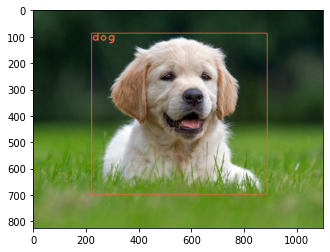

In [9]:
classes = []
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Load YOLO network
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Create random RGB array with number of classes
colors = np.random.uniform(0, 255, size=(len(classes), 3))

def load_image(name):
    img = cv2.imread(name)
    height, width = img.shape[:2]
    
    return img, height, width

def infer_image(img, output_layers):
    # pre-processing the image before feeding into the network
    blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (416, 416), (0, 0, 0), True, crop=False)

    # Feed the pre-processed blob to the network
    net.setInput(blob)

    # Fetch the result
    outs = net.forward(output_layers)

    return outs

def generate_bounding_boxes(outs, height, width, target_confidence):
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > target_confidence:
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    return boxes, confidences, class_ids

def draw_boxes(img, boxes, confidences, class_ids, indexes, colors, labels):
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(labels[class_ids[i]])
            color = colors[i]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y + 30), cv2.FONT_HERSHEY_PLAIN, 3, color, 3)

    return img

img, height, width = load_image('dog.jpg')
outs = infer_image(img, output_layers)
boxes, confidences, class_ids = generate_bounding_boxes(outs, height, width, 0.5)

# If boxes are collapsed, choose the one with the highest confidence
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)

img = draw_boxes(img, boxes, confidences, class_ids, indexes, colors, classes)

plt.imshow(img[:,:,[2,1,0]])
plt.show()

In [35]:
%%writefile src/yolo_inference.py

import os
import time
import sys
import json
import gluoncv
import mxnet as mx
import base64

ctx = mx.cpu()

def model_fn(model_dir=None):
    net = gluoncv.model_zoo.get_model(
        'yolo3_darknet53_coco',
        pretrained=True,
        ctx=ctx
    )
    
    return net
    
def input_fn(request_body, content_type):
    json_body = json.loads(request_body)
    image = base64.b64decode(json_body['image'])
    
    x, _ = gluoncv.data.transforms.presets.yolo.transform_test(
        mx.image.imdecode(image), short=416
    )
    
    return x

def predict_fn(input_object, model):
    class_ids, confidences, boxes = model(input_object.as_in_context(ctx))
    
    return input_object.shape, class_ids[0], confidences[0], boxes[0]
    
def output_fn(prediction, content_type):
    shape, class_ids, confidences, boxes = prediction
    
    return json.dumps({
        'shape': shape,
        'class_ids': class_ids.asnumpy().tolist(),
        'confidences': confidences.asnumpy().tolist(),
        'boxes': boxes.asnumpy().tolist()
    })

Overwriting src/yolo_inference.py


In [36]:
f = open("yolo3_darknet53_coco-symbol.json", 'w')
f.close()
f = open("yolo3_darknet53_coco-0000.params", 'w')
f.close()
!tar -czf model.tar.gz yolo3_darknet53_coco-symbol.json yolo3_darknet53_coco-0000.params

In [37]:
bucket = sagemaker.Session().default_bucket()
print(bucket)
s3 = boto3.client('s3')
s3.upload_file('model.tar.gz', bucket, 'yolo-model' + '/' + 'model.tar.gz')

sagemaker-ap-northeast-2-618970304109


In [38]:
%%time
model = MXNetModel(
    entry_point='yolo_inference.py',
    model_data='s3://{}/{}/{}'.format(bucket, 'yolo-model', 'model.tar.gz'),
    role=role,
    framework_version='1.6.0',
    source_dir='src',
    py_version='py3'
)

predictor = model.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.large'
)

-------------!CPU times: user 319 ms, sys: 29.3 ms, total: 348 ms
Wall time: 6min 32s


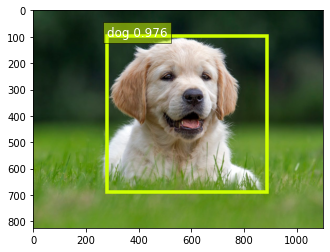

In [34]:
classes = []
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
            
def detect(filename):
    with open(filename, 'rb') as image:
        target = image.read()
        
    base64_string = {
        'image': base64.b64encode(target).decode('utf8')
    }
    
    orig_img = mx.image.imdecode(target)
    
    outputs = predictor.predict(base64_string)
    shape = outputs['shape']
    class_ids = mx.nd.array(outputs['class_ids'])
    confidences = mx.nd.array(outputs['confidences'])
    boxes = mx.nd.array(outputs['boxes'])
    boxes = gluoncv.data.transforms.bbox.resize(boxes, 
                                                (shape[2], shape[3]), 
                                                (orig_img.shape[0], orig_img.shape[1])
    )
    img = gluoncv.utils.viz.cv_plot_bbox(orig_img, bboxes=boxes, scores=confidences, labels=class_ids, class_names=classes)
    retval, buffer_img = cv2.imencode('.jpg', img[:,:,[2,1,0]])
    image_string = base64.b64encode(buffer_img).decode('utf8')
    
    ax = gluoncv.utils.viz.plot_bbox(orig_img, boxes, confidences, class_ids, class_names=classes)
    
detect('dog.jpg')

In [15]:
# predictor.delete_endpoint()